# Long & Short - Cointegração
#### Usando API Yahoo
- Observações Importantes.
    - O yahoo nos fornece históricos de diversos ativos, nos ativos brasileiros, em geral, após o ticker padrão devemos acrescentar '.SA'. Índices tem nomeclatura própria ('^BVSP' para Ibov e BRL=X para DOLFUT) .
    - É possível escolher o timeframe (há logicamente limitações no database)
    - Os preços geralmente já vem ajustados em função de split e dividendos, mas em comparações passadas já vi divergencias com Profit, da mesma forma que já vi entre Profit e Tryd.
    - Mais infos sobre como usar a biblioteca podem ser visto no link abaixo
    
https://pypi.org/project/yfinance/

### Importando bibliotecas.
- Quando começamos um projeto devemos primeiramente importar as bibliotecas que serão usadas no projeto, ou funções de biblioteca que serão usadas.
- O comando **import** permite que uma biblioteca ou uma função, caso antes seja explicitada a biblioteca com o comando **from**, seja importada.

In [2]:
import pandas as pd # Biblioteca padrão para controle de Dataframes
import numpy as np # Biblioteca padrão para arrays
from arch.unitroot import ADF # Função ADF para calculo da Cointegração
from sklearn.linear_model import LinearRegression # Função para executar uma regressão linear
from yellowbrick.regressor import ResidualsPlot # Função para plotar a distribuição dos resíduos de forma simplificada
import matplotlib.pyplot as plt # Biblioteca para plotar gráficos
import seaborn as sns # Biblioteca para plotar gráficos, difere da matplotlib por ter uma integração melhor com Dataframes
# Por fim, usaremos o yfinance para baixar dados de ativos no nosso programa.
import yfinance as yf 

# Apenas para evitar Warnings no arquivo
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [3]:
# Criando uma lista a partir de um arquivo csv que está localizado no meu Github
lista_ativos = list(pd.read_csv('https://raw.githubusercontent.com/Lessalc/Long-Short/main/ativos.txt'))
# Vou verificar quais são os 5 primeiros da lista
lista_ativos[:5]

['^BVSP', 'ABEV3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BBAS3.SA']

## Parte01 - Escolhendo dois ativos.
- BBSE3 x IGTA3

In [4]:
# Com a biblioteca YFinance, aqui importada pelo alias de yf, usarei o método '.download()' para baixar os dados dos ativos 
dados = yf.download(tickers = ['BBSE3.SA', 'IGTA3.SA'], period='5y', interval='1d', auto_adjust=True)

[*********************100%***********************]  2 of 2 completed


In [5]:
# Vamos visualizar o que foi baixado. Método head do pandas nos mostra as linhas iniciais do nosso dataframe
dados.head()

Close                  High                   Low             \
             BBSE3.SA   IGTA3.SA   BBSE3.SA   IGTA3.SA   BBSE3.SA   IGTA3.SA   
Date                                                                           
2016-02-05  16.020975  19.680740  16.081054  19.959241  15.560372  19.402238   
2016-02-10  16.020975  19.346540  16.020975  19.485791  15.580398  18.854521   
2016-02-11  15.420189  19.012339  15.880792  19.142307  15.166523  18.780254   
2016-02-12  15.420189  19.030905  15.620451  19.123739  15.239953  18.826671   
2016-02-15  15.693881  18.752405  15.887467  19.300124  15.560372  18.752405   

                 Open                Volume            
             BBSE3.SA   IGTA3.SA   BBSE3.SA  IGTA3.SA  
Date                                                   
2016-02-05  15.573723  19.420805  6683200.0  460600.0  
2016-02-10  15.820713  19.309406  4122400.0  280700.0  
2016-02-11  15.760635  19.049473  6032500.0  845500.0  
2016-02-12  15.620451  18.900938  4523200.0  707700.0  
2016-02-15  15.680530  19.049473  2311900.0  161900.0

In [6]:
# No nosso caso só precisamos de dados de fechamento
dados = dados['Close']
dados.head()

BBSE3.SA   IGTA3.SA
Date                            
2016-02-05  16.020975  19.680740
2016-02-10  16.020975  19.346540
2016-02-11  15.420189  19.012339
2016-02-12  15.420189  19.030905
2016-02-15  15.693881  18.752405

In [7]:
# O método info do pandas permite visualizar resumidamente nossos dados. Inclusive se há dados faltantes
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1245 entries, 2016-02-05 to 2021-02-05
Data columns (total 2 columns):
BBSE3.SA    1243 non-null float64
IGTA3.SA    1243 non-null float64
dtypes: float64(2)
memory usage: 29.2 KB


In [8]:
# Podemos ver que temos 1245 entradas nas quais as colunas BBSE3.SA e IGTA3.SA possuem 1243 dados não faltantes (non-null)
# Iremos deletar os dados faltantes, esse não é geralmente o tratamento padrão de dados. 
# É importante estudar oq está faltando, mas no nosso caso isso não é necessário

dados.dropna(axis=0, how='all', inplace=True)

In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1243 entries, 2016-02-05 to 2021-02-05
Data columns (total 2 columns):
BBSE3.SA    1243 non-null float64
IGTA3.SA    1243 non-null float64
dtypes: float64(2)
memory usage: 29.1 KB


In [10]:
dados.head()

BBSE3.SA   IGTA3.SA
Date                            
2016-02-05  16.020975  19.680740
2016-02-10  16.020975  19.346540
2016-02-11  15.420189  19.012339
2016-02-12  15.420189  19.030905
2016-02-15  15.693881  18.752405

In [11]:
# Criando uma lista de períodos no qual iremos verificar se o par de ativo é ou não Cointegrado.
periodos = [250, 200, 150, 120, 100]

In [12]:
""" Nesse código iremos fazer uma iteração nos períodos acima definidos, com os ativos que estamos estudando.
Iniciamos gerando um novo Dataframe, que será um subconjunto do Dataframe 'dados', mas agora com os últimos n-períodos, 
onde n é o período da lista acima criada.
Após criar o novo dataframe, iremos separar os ativos em Ativo Independente (X) e Ativo Dependente (y), retornaremos a 
correlação entre eles e faremos uma regressão linear. Iremos gerar os valores de y previstos a partir da regressão e 
teremos os resídos que é a diferença entre o observado (y) e previsto (y_pred).
Por fim usaremos a função ADF que retorna um objeto com as informações do teste ADF sobre os resíduos.
O que nos interessa é o valor estatítico do teste ADF e o valor crítico. Sendo valor estatístico < valor crítico, 
classificamos como cointegrados.
"""

for n in periodos:
    dados_n = dados.iloc[-n:, :]
    # Printando o intervalo
    print('####################')
    print('Intervalo: {:.0f}'.format(n))
    ###### REGRESSÃO E RESÍDUOS #################################
    # Separando a variável independente e dependente
    X = dados_n.iloc[:, 0].values
    y = dados_n.iloc[:, 1].values
    # Printando a correlação
    print('Correlação: {:.3f}'.format(np.corrcoef(X,y)[0,1]))
    # Reordenando para Regressão Linear
    X = X.reshape(-1, 1)
    # Criando e treinando o modelo
    modelo = LinearRegression()
    modelo.fit(X,y)
    # Gerando os valores previstos e calculando o resíduo
    y_pred = modelo.predict(X)                
    residuos = y - y_pred                
    # Teste ADF
    adf = ADF(residuos)
    print('Estátistica do intervalo: {:.3f}'.format(adf.stat))

    print('Valor crítico ADF 95%: {:.3f}. Ativo cointegrado com 95%? {}'.format(adf.critical_values['5%'], (adf.stat < adf.critical_values['5%'])))
    print('Valor crítico ADF 99%: {:.3f}. Ativo cointegrado com 99%? {}'.format(adf.critical_values['1%'], (adf.stat < adf.critical_values['1%'])))

####################
Intervalo: 250
Correlação: 0.824
Estátistica do intervalo: -3.250
Valor crítico ADF 95%: -2.873. Ativo cointegrado com 95%? True
Valor crítico ADF 99%: -3.457. Ativo cointegrado com 99%? False
####################
Intervalo: 200
Correlação: 0.753
Estátistica do intervalo: -4.254
Valor crítico ADF 95%: -2.876. Ativo cointegrado com 95%? True
Valor crítico ADF 99%: -3.464. Ativo cointegrado com 99%? True
####################
Intervalo: 150
Correlação: 0.713
Estátistica do intervalo: -3.439
Valor crítico ADF 95%: -2.881. Ativo cointegrado com 95%? True
Valor crítico ADF 99%: -3.475. Ativo cointegrado com 99%? False
####################
Intervalo: 120
Correlação: 0.735
Estátistica do intervalo: -2.970
Valor crítico ADF 95%: -2.886. Ativo cointegrado com 95%? True
Valor crítico ADF 99%: -3.487. Ativo cointegrado com 99%? False
####################
Intervalo: 100
Correlação: 0.736
Estátistica do intervalo: -2.539
Valor crítico ADF 95%: -2.891. Ativo cointegrado com 95%? 

### Conclusão parte 01
- O código acima é suficiente para classificar um par de ativos e repetir o processo para n-pares
- Pouco eficiente para retornar todos os pares, afinal, estamos imprimindo em tela os valores.
- O par usado só é cointegrado com 99% de confiança em um período (200 dias). 
- O par é dito não cointegrado em um período de 100 dias.

## Parte02 - Gerando os gráficos dos ativos.
- Iremos gerar os gráficos com o período que melhor e pior performou nos testes (200 e 100 períodos)

In [13]:
# O índice usado anteriormente (datas) será agora uma coluna.
dados.reset_index(inplace=True)

In [14]:
dados_100 = dados.iloc[-100:, :]
dados_200 = dados.iloc[-200:, :]

In [15]:
dados_100.head()

Date   BBSE3.SA   IGTA3.SA
1143 2020-09-09  26.600000  35.299999
1144 2020-09-10  26.280001  34.730000
1145 2020-09-11  25.469999  34.110001
1146 2020-09-14  25.860001  35.990002
1147 2020-09-15  26.100000  36.070000

### Para 100 Períodos

In [16]:
# Gerando a Regressão e os resíduos
X = dados_100.iloc[:, 1].values
y = dados_100.iloc[:, 2].values

# Reordenando para Regressão Linear
X = X.reshape(-1, 1)
# Criando e treinando o modelo
modelo = LinearRegression()
modelo.fit(X,y)
# Gerando os valores previstos e calculando o resíduo
y_pred = modelo.predict(X)                
residuos = y - y_pred
# Calculando o Desvio padrão e a Média dos resíduos
desvio = np.std(residuos)
media = np.mean(residuos)
# Padronizando o resíduo. 
residuos_padronizado = residuos/np.std(residuos)

- Na pasta long&Short está incluso um tutorial da biblioteca Matplotlib, para quem quiser entender melhor como montar os gráficos.

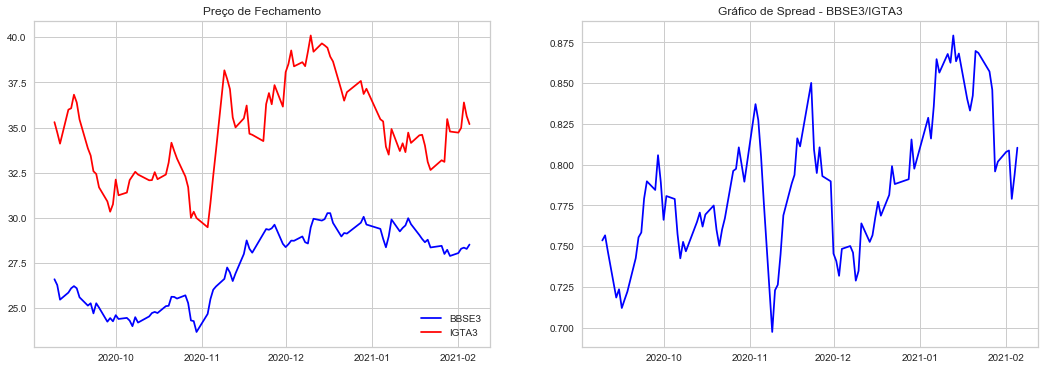

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax1.set_title('Preço de Fechamento')
ax1.plot(dados_100['Date'], dados_100['BBSE3.SA'], color='blue', label='BBSE3')
ax1.plot(dados_100['Date'], dados_100['IGTA3.SA'], color='red', label='IGTA3')
ax1.legend(loc=4);

ax2.set_title('Gráfico de Spread - BBSE3/IGTA3')
arr = dados_100['BBSE3.SA'].values/dados_100['IGTA3.SA'].values
ax2.plot(dados_100['Date'], arr, color='blue', label='Spread')

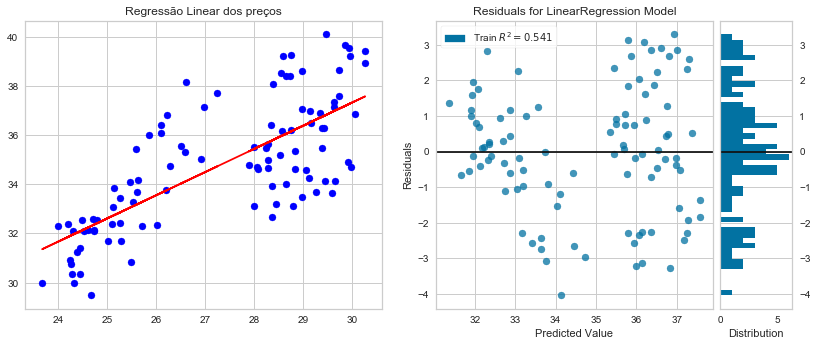

<Figure size 504x504 with 0 Axes>

In [18]:
plt.axes([0.05,0.05,0.825,1])
plt.title('Regressão Linear dos preços')
plt.scatter(X, y, color='blue')
plt.plot(X, modelo.predict(X), color='red')

plt.axes([1,0.05,0.825,1])
visualizador = ResidualsPlot(modelo)
plt.figure(figsize=(7, 7))
visualizador.fit(X, y)
visualizador.finalize()

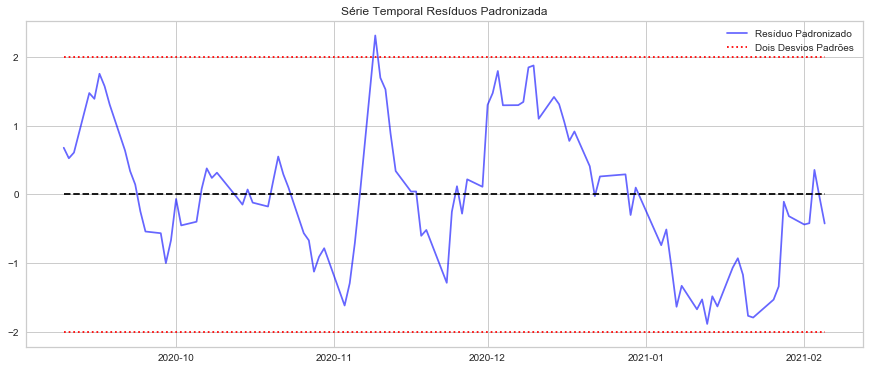

In [19]:
plt.figure(figsize=(15, 6))
plt.title('Série Temporal Resíduos Padronizada')
plt.plot(dados_100['Date'], residuos_padronizado , color='blue', alpha = 0.6, label='Resíduo Padronizado')
plt.plot(dados_100['Date'], np.repeat(media,n) , color='black', linestyle='--')
plt.plot(dados_100['Date'], np.repeat(2,n) , color='red', linestyle=':', label='Dois Desvios Padrões')
plt.plot(dados_100['Date'], np.repeat(-2,n) , color='red', linestyle=':')

plt.legend(loc=0)

### Para 200

In [24]:
# Gerando a Regressão e os resíduos
X = dados_200.iloc[:, 1].values
y = dados_200.iloc[:, 2].values

# Reordenando para Regressão Linear
X = X.reshape(-1, 1)
# Criando e treinando o modelo
modelo = LinearRegression()
modelo.fit(X,y)
# Gerando os valores previstos e calculando o resíduo
y_pred = modelo.predict(X)                
residuos = y - y_pred
desvio = np.std(residuos)
media = np.mean(residuos)
residuos_padronizado = residuos/np.std(residuos)

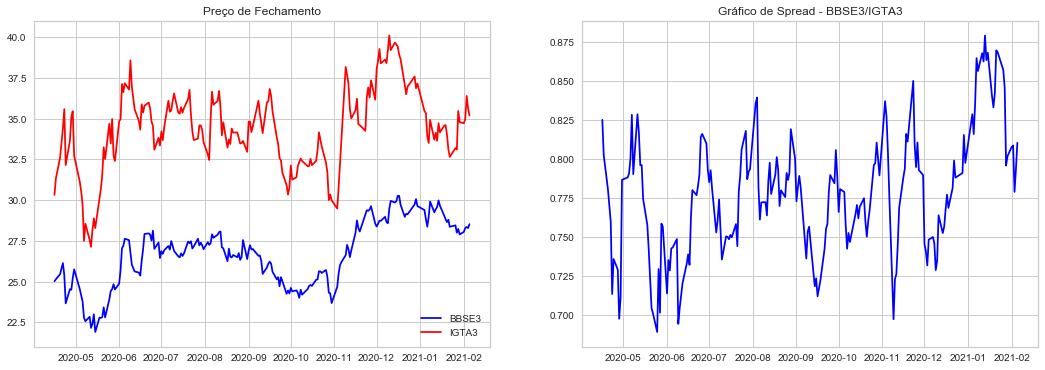

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax1.set_title('Preço de Fechamento')
ax1.plot(dados_200['Date'], dados_200['BBSE3.SA'], color='blue', label='BBSE3')
ax1.plot(dados_200['Date'], dados_200['IGTA3.SA'], color='red', label='IGTA3')
ax1.legend(loc=4);

ax2.set_title('Gráfico de Spread - BBSE3/IGTA3')
arr = dados_200['BBSE3.SA'].values/dados_200['IGTA3.SA'].values
ax2.plot(dados_200['Date'], arr, color='blue', label='Spread')

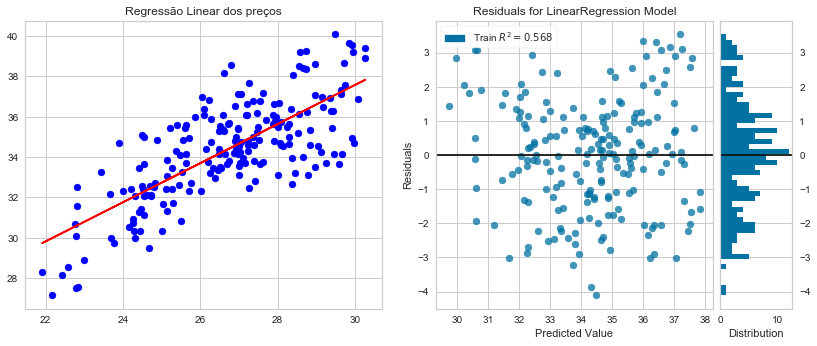

<Figure size 504x504 with 0 Axes>

In [22]:
plt.axes([0.05,0.05,0.825,1])
plt.title('Regressão Linear dos preços')
plt.scatter(X, y, color='blue')
plt.plot(X, modelo.predict(X), color='red')

plt.axes([1,0.05,0.825,1])
visualizador = ResidualsPlot(modelo)
plt.figure(figsize=(7, 7))
visualizador.fit(X, y)
visualizador.finalize()

plt.show()

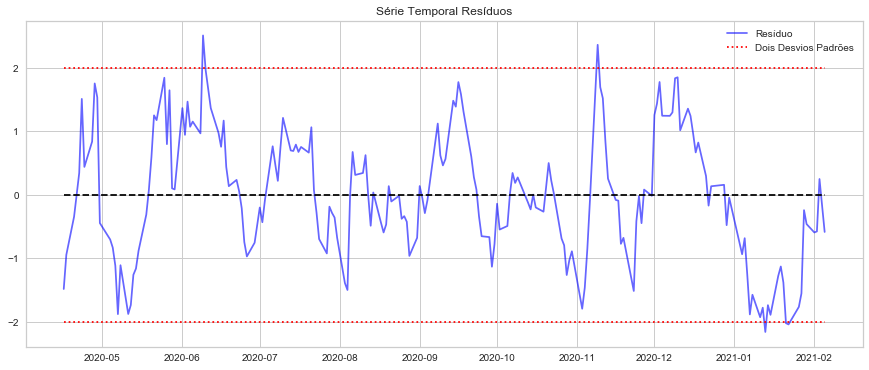

In [26]:
plt.figure(figsize=(15, 6))
plt.title('Série Temporal Resíduos')
plt.plot(dados_200['Date'], residuos_padronizado , color='blue', alpha = 0.6, label='Resíduo')
plt.plot(dados_200['Date'], np.repeat(media,200) , color='black', linestyle='--')
plt.plot(dados_200['Date'], np.repeat(2,200) , color='red', linestyle=':', label='Dois Desvios Padrões')
plt.plot(dados_200['Date'], np.repeat(-2,200) , color='red', linestyle=':')

plt.legend(loc=0)
plt.show()

### Conclusão parte 02
- Essa segunda parte foi elaborada para enteder o gráfico dos ativos. 
- Os períodos foram escolhidos por possuir resultados opostos, no de 100 periodos não tinhamos evidência estatítica suficiente para a cointegração. Já no segundo caso, com 200 períodos o teste ADF indicou que os ativos estavam cointegrados.
- O código usado acima pode ser repetido diversas vezes para diversos ativos em diversos períodos.
- Na série temporal dos resíduos quanto mais vezes o resíduo passa pelo 0 melhor. A cointegração diz q a série é estacionária e espera que retorne a média.

## Parte 03 - Gerando um mapa de probabilidade do teste ADF entre pares de Ativos
- A ideia agora é com os ativos do IBOV testar a ADF para um período de escolha e retornar a estatística do teste ADF e com isso gerar uma tabela de cointegração.
- Se usarmos todos os ativos IBOV teremos um problema para visualizar. Assim, iremos escolher aleatoriamente alguns ativos e gerar a estatística. Pode-se salvar a imagem na sua máquina e fazer o teste para todo o IBOV, usando o zoom da imagem para ir acompanhando. 

In [27]:
# Importando novos dados. Todos os Ativos do IBOV com 1 anos de dados
# Usarei 200 períodos para gerar a estatística, assim, não preciso de mais de 1 ano de dados
dados = yf.download(tickers = lista_ativos, period='1y', interval='1d', auto_adjust=True)
# Entre os arquivos temos o IBOV, que será usado apenas para organizar os dados

[*********************100%***********************]  83 of 83 completed

1 Failed download:
- UNNAMED: 82: No data found, symbol may be delisted


In [28]:
dados = dados['Close']

In [29]:
dados.head()

ABEV3.SA   AZUL4.SA   B3SA3.SA   BBAS3.SA   BBDC3.SA   BBDC4.SA  \
Date                                                                           
2020-02-05  16.725931  61.270000  47.722412  48.447281  28.534712  29.848398   
2020-02-06  16.357475  59.070000  47.084187  47.630211  28.136675  29.503376   
2020-02-07  16.405956  56.290001  46.707047  47.678276  28.048223  29.839548   
2020-02-10  16.221729  56.820000  47.026165  47.207264  28.198593  30.158030   
2020-02-11  16.289602  58.340000  47.287258  49.331635  28.968128  30.423424   

             BBSE3.SA   BEEF3.SA  BPAC11.SA   BRAP4.SA  ...   TOTS3.SA  \
Date                                                    ...              
2020-02-05  31.859825  11.747002  77.359238  37.269234  ...  25.864513   
2020-02-06  32.016224  11.552835  76.954781  37.336369  ...  25.342266   
2020-02-07  32.531429  10.844132  75.988037  36.271809  ...  24.942318   
2020-02-10  32.954632  10.368427  72.505783  35.399059  ...  24.634916   
2020-02-11  33.920639  11.057714  75.208725  37.058239  ...  24.859682   

             UGPA3.SA  UNNAMED: 82   USIM5.SA   VALE3.SA   VIVT3.SA  VVAR3.SA  \
Date                                                                            
2020-02-05  25.091545          NaN  10.175259  50.863770  47.851894     15.14   
2020-02-06  24.775557          NaN   9.947380  51.142128  47.997963     14.85   
2020-02-07  24.034956          NaN   9.531255  50.009476  47.377224     14.32   
2020-02-10  23.639969          NaN   9.204299  48.176117  47.450245     13.79   
2020-02-11  24.785431          NaN   9.828487  49.961483  48.290077     14.62   

             WEGE3.SA   YDUQ3.SA     ^BVSP  
Date                                        
2020-02-05  41.039566  54.473152  116028.0  
2020-02-06  42.497826  52.667194  115190.0  
2020-02-07  40.771721  51.823105  113770.0  
2020-02-10  41.198284  51.185135  112570.0  
2020-02-11  42.706146  52.019405  115371.0  

[5 rows x 83 columns]

- Quando extraimos arquivos do Yahoo encontramos NaNs. não podemos trabalhar com NaNs nos nossos dados. 
- Primeiro Vamos organizar os dados. Se houver qualquer linha na qual  IBOV seja NAN ela deverá ser excluída.
- Depois iremos fazer um subset com 200 dados, ou n qualquer q seja definido, excluindo todas as colunas q tiverem NaNs

In [30]:
dados.shape

(248, 83)

In [31]:
dados = dados.loc[dados['^BVSP'].notna(), :]

In [32]:
dados.shape

(246, 83)

In [33]:
n = 200
dados = dados.iloc[-n:, :] 
# Definido n (o intervalo). O novo dataframe dados irá pegar todos os dados com as linhas variando de -n até o fim e todas as colunas
dados.shape

(200, 83)

In [34]:
dados.dropna(axis=1, how='any', inplace=True) # Agora devemos excluir todas as colunas que tiverem qualquer valor NaN
print(dados.shape)
dados.dropna(axis=0, how='all', inplace=True) # Por fim, não pode haver linhas NaNs
print(dados.shape)

(200, 81)
(200, 81)


In [35]:
# Vamos gerar numeros aleatórios que serão usados para definir os ativos
import random
random.seed(150) # Seed permite gerar um falso aleatório, gerando a mesma amostra em qualquer máquina.
amostra = random.sample(range(dados.shape[1]-1), 15)
amostra
# Definimos nossa amostra

[41, 51, 24, 29, 38, 61, 18, 20, 53, 11, 37, 42, 36, 56, 50]

In [36]:
novos_dados = dados.iloc[:, amostra]
#novos_dados.reset_index(inplace=True)

In [37]:
novos_dados.head()

HAPV3.SA   LAME4.SA  CVCB3.SA   ELET6.SA   GNDI3.SA   PETR4.SA  \
Date                                                                          
2020-04-15  10.364827  21.348558     14.50  25.551126  54.740002  16.378786   
2020-04-16  10.346906  22.181479     14.60  24.800627  54.930000  15.718835   
2020-04-17  10.434523  21.566704     14.67  25.022366  55.599998  16.128803   
2020-04-20  10.767075  22.637602     14.56  24.911495  57.540001  15.948816   
2020-04-22  10.615733  24.957882     14.85  25.559654  56.849998  16.748756   

            COGN3.SA   CPLE6.SA   LREN3.SA   BRFS3.SA   GGBR4.SA   HGTX3.SA  \
Date                                                                          
2020-04-15      5.25  54.912750  35.166538  19.049999  11.171323  14.083617   
2020-04-16      5.11  54.269989  35.068172  19.270000  11.438011  14.093357   
2020-04-17      5.04  54.327553  37.281147  19.049999  12.149184  13.343399   
2020-04-20      5.09  54.509827  38.772392  18.920000  11.704701  14.064137   
2020-04-22      5.08  56.639568  40.691132  19.450001  11.556540  14.999149   

             FLRY3.SA   MRVE3.SA  KLBN11.SA  
Date                                         
2020-04-15  22.277056  13.047779  16.120001  
2020-04-16  22.514889  12.960406  15.940000  
2020-04-17  23.505861  12.970114  15.850000  
2020-04-20  24.358097  13.300192  15.950000  
2020-04-22  24.031076  14.173927  16.530001

In [38]:
df = pd.DataFrame(columns=novos_dados.columns)
df.head()

Empty DataFrame
Columns: [HAPV3.SA, LAME4.SA, CVCB3.SA, ELET6.SA, GNDI3.SA, PETR4.SA, COGN3.SA, CPLE6.SA, LREN3.SA, BRFS3.SA, GGBR4.SA, HGTX3.SA, FLRY3.SA, MRVE3.SA, KLBN11.SA]
Index: []

In [39]:
# Aqui iremos gerar um dataframe com os valores da estatística do ADF
# Para cada ativo iremos executar o teste ADF com cada um dos outros ativos selecionados.
for i in range(len(novos_dados.columns)):
    ativo_x = novos_dados.columns[i]
    for j in range(len(novos_dados.columns)):
        ativo_y = novos_dados.columns[j]
        if ativo_x == ativo_y:
            df.loc[ativo_x, ativo_y] = 0
        else:
            X = novos_dados.iloc[:, i].values
            y = novos_dados.iloc[:, j].values
            # Reordenando para Regressão Linear
            X = X.reshape(-1, 1)
            # Criando e treinando o modelo
            modelo = LinearRegression()
            modelo.fit(X,y)
            # Gerando os valores previstos e calculando o resíduo
            y_pred = modelo.predict(X)                
            residuos = y - y_pred                
            # Teste ADF
            adf = ADF(residuos)
            df.loc[ativo_x, ativo_y] = adf.stat

In [40]:
# O valor retornado é do tipo "object", vamos transformar em float
for coluna in list(df.columns):
    df[coluna] = pd.to_numeric(df[coluna], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, HAPV3.SA to KLBN11.SA
Data columns (total 15 columns):
HAPV3.SA     15 non-null float64
LAME4.SA     15 non-null float64
CVCB3.SA     15 non-null float64
ELET6.SA     15 non-null float64
GNDI3.SA     15 non-null float64
PETR4.SA     15 non-null float64
COGN3.SA     15 non-null float64
CPLE6.SA     15 non-null float64
LREN3.SA     15 non-null float64
BRFS3.SA     15 non-null float64
GGBR4.SA     15 non-null float64
HGTX3.SA     15 non-null float64
FLRY3.SA     15 non-null float64
MRVE3.SA     15 non-null float64
KLBN11.SA    15 non-null float64
dtypes: float64(15)
memory usage: 2.5+ KB


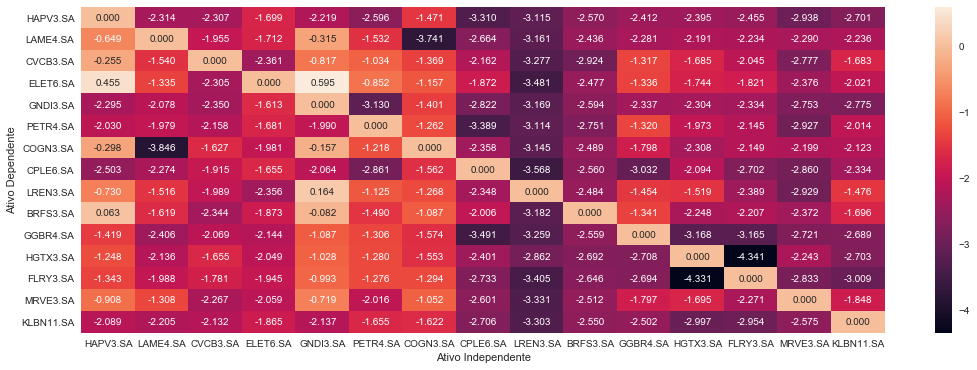

In [41]:
# Criando o mapa de calor
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
# A biblioteca seaborn se comunica muito bem com dataframes
sns.heatmap(df, annot=True, fmt=".3f", ax=ax1)
# annot= True - permite escrever os valores, fmt='.3f' - formatação, no caso float com 3 casas decimais
ax1.set_xlabel('Ativo Independente')
ax1.set_ylabel('Ativo Dependente');

### Observação importante.
- O valor retornado no teste ADF é diferente quando mudandos a ordem do par. Sendo em alguns caso dito Cointegrado um par e se for invertida a ordem (o independente virando dependente e vice-versa) o par pode ser dito não Cointegrado. Vamos pegar o exemplo. LREN3 e KLBN11

### LREN3 (Independente) x KLBN11 (Dependente)

In [42]:
# Gerando a Regressão e os resíduos
X = novos_dados.iloc[:, 8].values # LREN3
y = novos_dados.iloc[:, 14].values # KLBN11

# Reordenando para Regressão Linear
X = X.reshape(-1, 1)
# Criando e treinando o modelo
modelo = LinearRegression()
modelo.fit(X,y)
# Gerando os valores previstos e calculando o resíduo
y_pred = modelo.predict(X)                
residuos = y - y_pred
desvio = np.std(residuos)
media = np.mean(residuos)
residuos_padronizado = residuos/np.std(residuos)

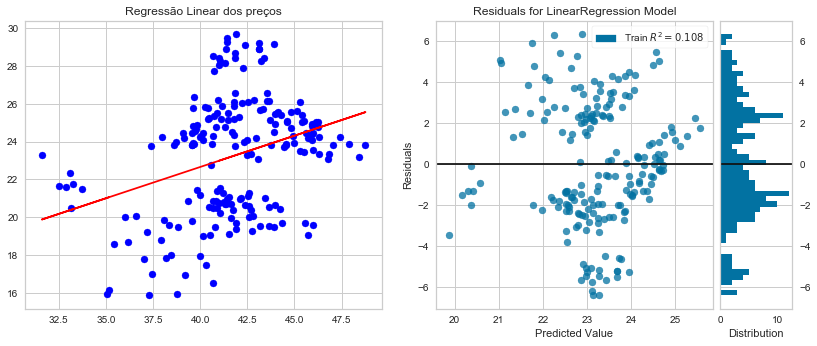

<Figure size 504x504 with 0 Axes>

In [43]:
plt.axes([0.05,0.05,0.825,1])
plt.title('Regressão Linear dos preços')
plt.scatter(X, y, color='blue')
plt.plot(X, modelo.predict(X), color='red')

plt.axes([1,0.05,0.825,1])
visualizador = ResidualsPlot(modelo)
plt.figure(figsize=(7, 7))
visualizador.fit(X, y)
visualizador.finalize()

plt.show()

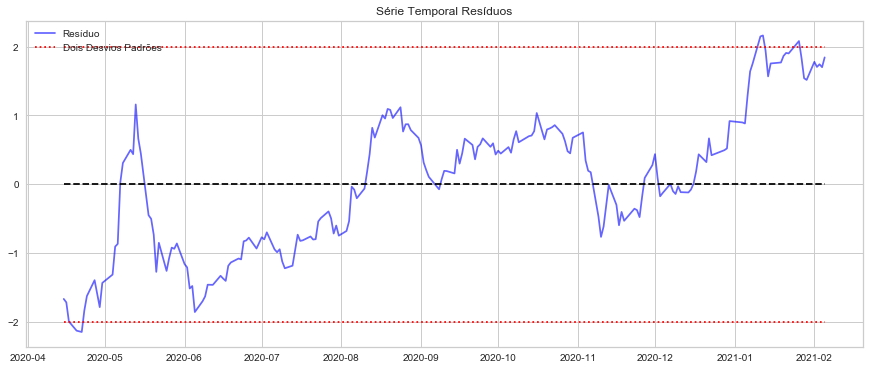

In [45]:
plt.figure(figsize=(15, 6))
plt.title('Série Temporal Resíduos')
plt.plot(novos_dados.index, residuos_padronizado , color='blue', alpha = 0.6, label='Resíduo')
plt.plot(novos_dados.index, np.repeat(media,n) , color='black', linestyle='--')
plt.plot(novos_dados.index, np.repeat(2,200) , color='red', linestyle=':', label='Dois Desvios Padrões')
plt.plot(novos_dados.index, np.repeat(-2,200) , color='red', linestyle=':')

plt.legend(loc=0)
plt.show()

###  KLBN11 (Independente) x LREN3 (Dependente)

In [46]:
# Gerando a Regressão e os resíduos
X = novos_dados.iloc[:, 14].values # KLBN11
y = novos_dados.iloc[:, 8].values # LREN3

# Reordenando para Regressão Linear
X = X.reshape(-1, 1)
# Criando e treinando o modelo
modelo = LinearRegression()
modelo.fit(X,y)
# Gerando os valores previstos e calculando o resíduo
y_pred = modelo.predict(X)                
residuos = y - y_pred
desvio = np.std(residuos)
media = np.mean(residuos)
residuos_padronizado = residuos/np.std(residuos)

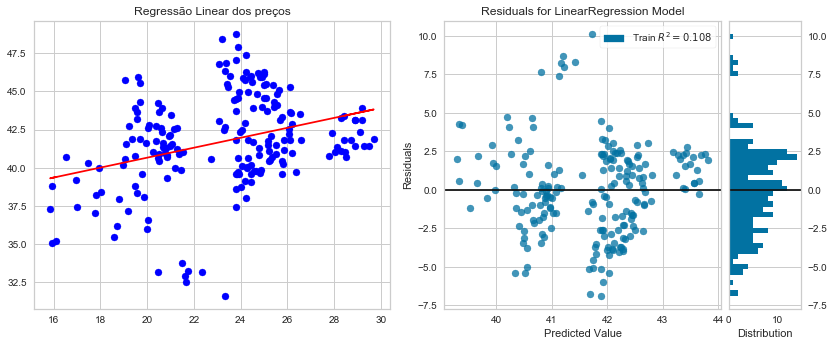

<Figure size 504x504 with 0 Axes>

In [47]:
plt.axes([0.05,0.05,0.825,1])
plt.title('Regressão Linear dos preços')
plt.scatter(X, y, color='blue')
plt.plot(X, modelo.predict(X), color='red')

plt.axes([1,0.05,0.825,1])
visualizador = ResidualsPlot(modelo)
plt.figure(figsize=(7, 7))
visualizador.fit(X, y)
visualizador.finalize()

plt.show()

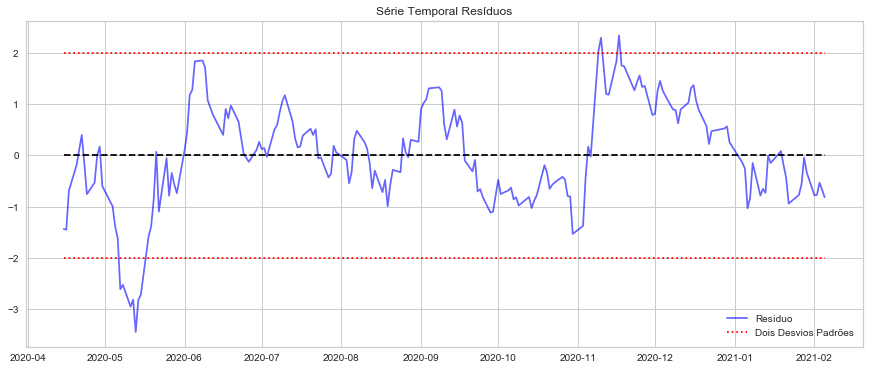

In [48]:
plt.figure(figsize=(15, 6))
plt.title('Série Temporal Resíduos')
plt.plot(novos_dados.index, residuos_padronizado , color='blue', alpha = 0.6, label='Resíduo')
plt.plot(novos_dados.index, np.repeat(media,n) , color='black', linestyle='--')
plt.plot(novos_dados.index, np.repeat(2,200) , color='red', linestyle=':', label='Dois Desvios Padrões')
plt.plot(novos_dados.index, np.repeat(-2,200) , color='red', linestyle=':')

plt.legend(loc=0)
plt.show()

### Conclusão parte 03
- Vimos que é possível gerar um dataframe com a estatística do ADF
- A partir disso montar um mapa de cor e acompanhar como estão as estatísticas em diversos pares de ativos.
- Visualmente temos boas informações, falta agora automatizar.

## Salvando uma figura na máquina
- Aqui irei gerar o heatmap para todos os ativos IBOV e salvar na maquina, para quem quiser repetir o código.
- Primeiro montamos o dataframe com as estatísticas para depois montar o heatmap

In [49]:
df = pd.DataFrame(columns=dados.columns)
df.head()

for i in range(len(dados.columns)):
    ativo_x = dados.columns[i]
    for j in range(len(dados.columns)):
        ativo_y = dados.columns[j]
        if ativo_x == ativo_y:
            df.loc[ativo_x, ativo_y] = 0
        else:
            X = dados.iloc[:, i].values
            y = dados.iloc[:, j].values
            # Reordenando para Regressão Linear
            X = X.reshape(-1, 1)
            # Criando e treinando o modelo
            modelo = LinearRegression()
            modelo.fit(X,y)
            # Gerando os valores previstos e calculando o resíduo
            y_pred = modelo.predict(X)                
            residuos = y - y_pred                
            # Teste ADF
            adf = ADF(residuos)
            df.loc[ativo_x, ativo_y] = adf.stat

In [53]:
df.head()

ABEV3.SA  AZUL4.SA B3SA3.SA BBAS3.SA BBDC3.SA BBDC4.SA BBSE3.SA  \
ABEV3.SA        0  -1.99082 -2.11465 -2.99946 -3.90158 -3.36685 -3.06891   
AZUL4.SA -2.58414         0 -1.80898 -2.16273 -2.65815 -2.65637  -2.6376   
B3SA3.SA -1.93729 -0.786648        0 -2.43602 -2.14816 -1.38364 -2.36426   
BBAS3.SA -2.72467 -0.972226 -2.22763        0 -2.06109 -1.56955 -3.80019   
BBDC3.SA -3.95026  -2.10927 -2.45188 -2.45371        0 -3.10265 -4.10284   

         BEEF3.SA BPAC11.SA BRAP4.SA  ... TAEE11.SA TOTS3.SA UGPA3.SA  \
ABEV3.SA -2.43618  -2.11286 -2.34914  ...  -2.41244 -2.04122 -2.30697   
AZUL4.SA -3.30882  -1.90383 -3.51787  ...  -3.32242 -1.86347 -2.89137   
B3SA3.SA -1.87792  -2.19442 -1.02761  ... -0.677739 -2.38659 -1.73553   
BBAS3.SA -1.82405  -1.71903 -1.93372  ...  -1.88351 -2.08894 -2.20387   
BBDC3.SA -2.31889  -2.37224 -2.81358  ...  -3.21316 -1.70608 -2.95755   

         USIM5.SA  VALE3.SA VIVT3.SA VVAR3.SA WEGE3.SA YDUQ3.SA    ^BVSP  
ABEV3.SA -1.89612  -2.66835 -3.09908 -2.32134 -1.65337 -2.68869 -2.68188  
AZUL4.SA -2.44668  -2.89418 -3.10403 -2.26946 -2.35804 -2.10792 -2.51615  
B3SA3.SA -1.29755 -0.614736 -1.69012 -1.51452 -1.29664 -2.04652 -1.26197  
BBAS3.SA -1.85106  -1.67554 -1.42794 -2.47321 -1.47789  -2.3795 -2.08237  
BBDC3.SA -2.42481  -2.81035 -3.08866 -2.30856 -2.04463  -2.2965 -3.64605  

[5 rows x 81 columns]

In [57]:
for coluna in list(df.columns):
    df[coluna] = pd.to_numeric(df[coluna], errors='coerce')

''

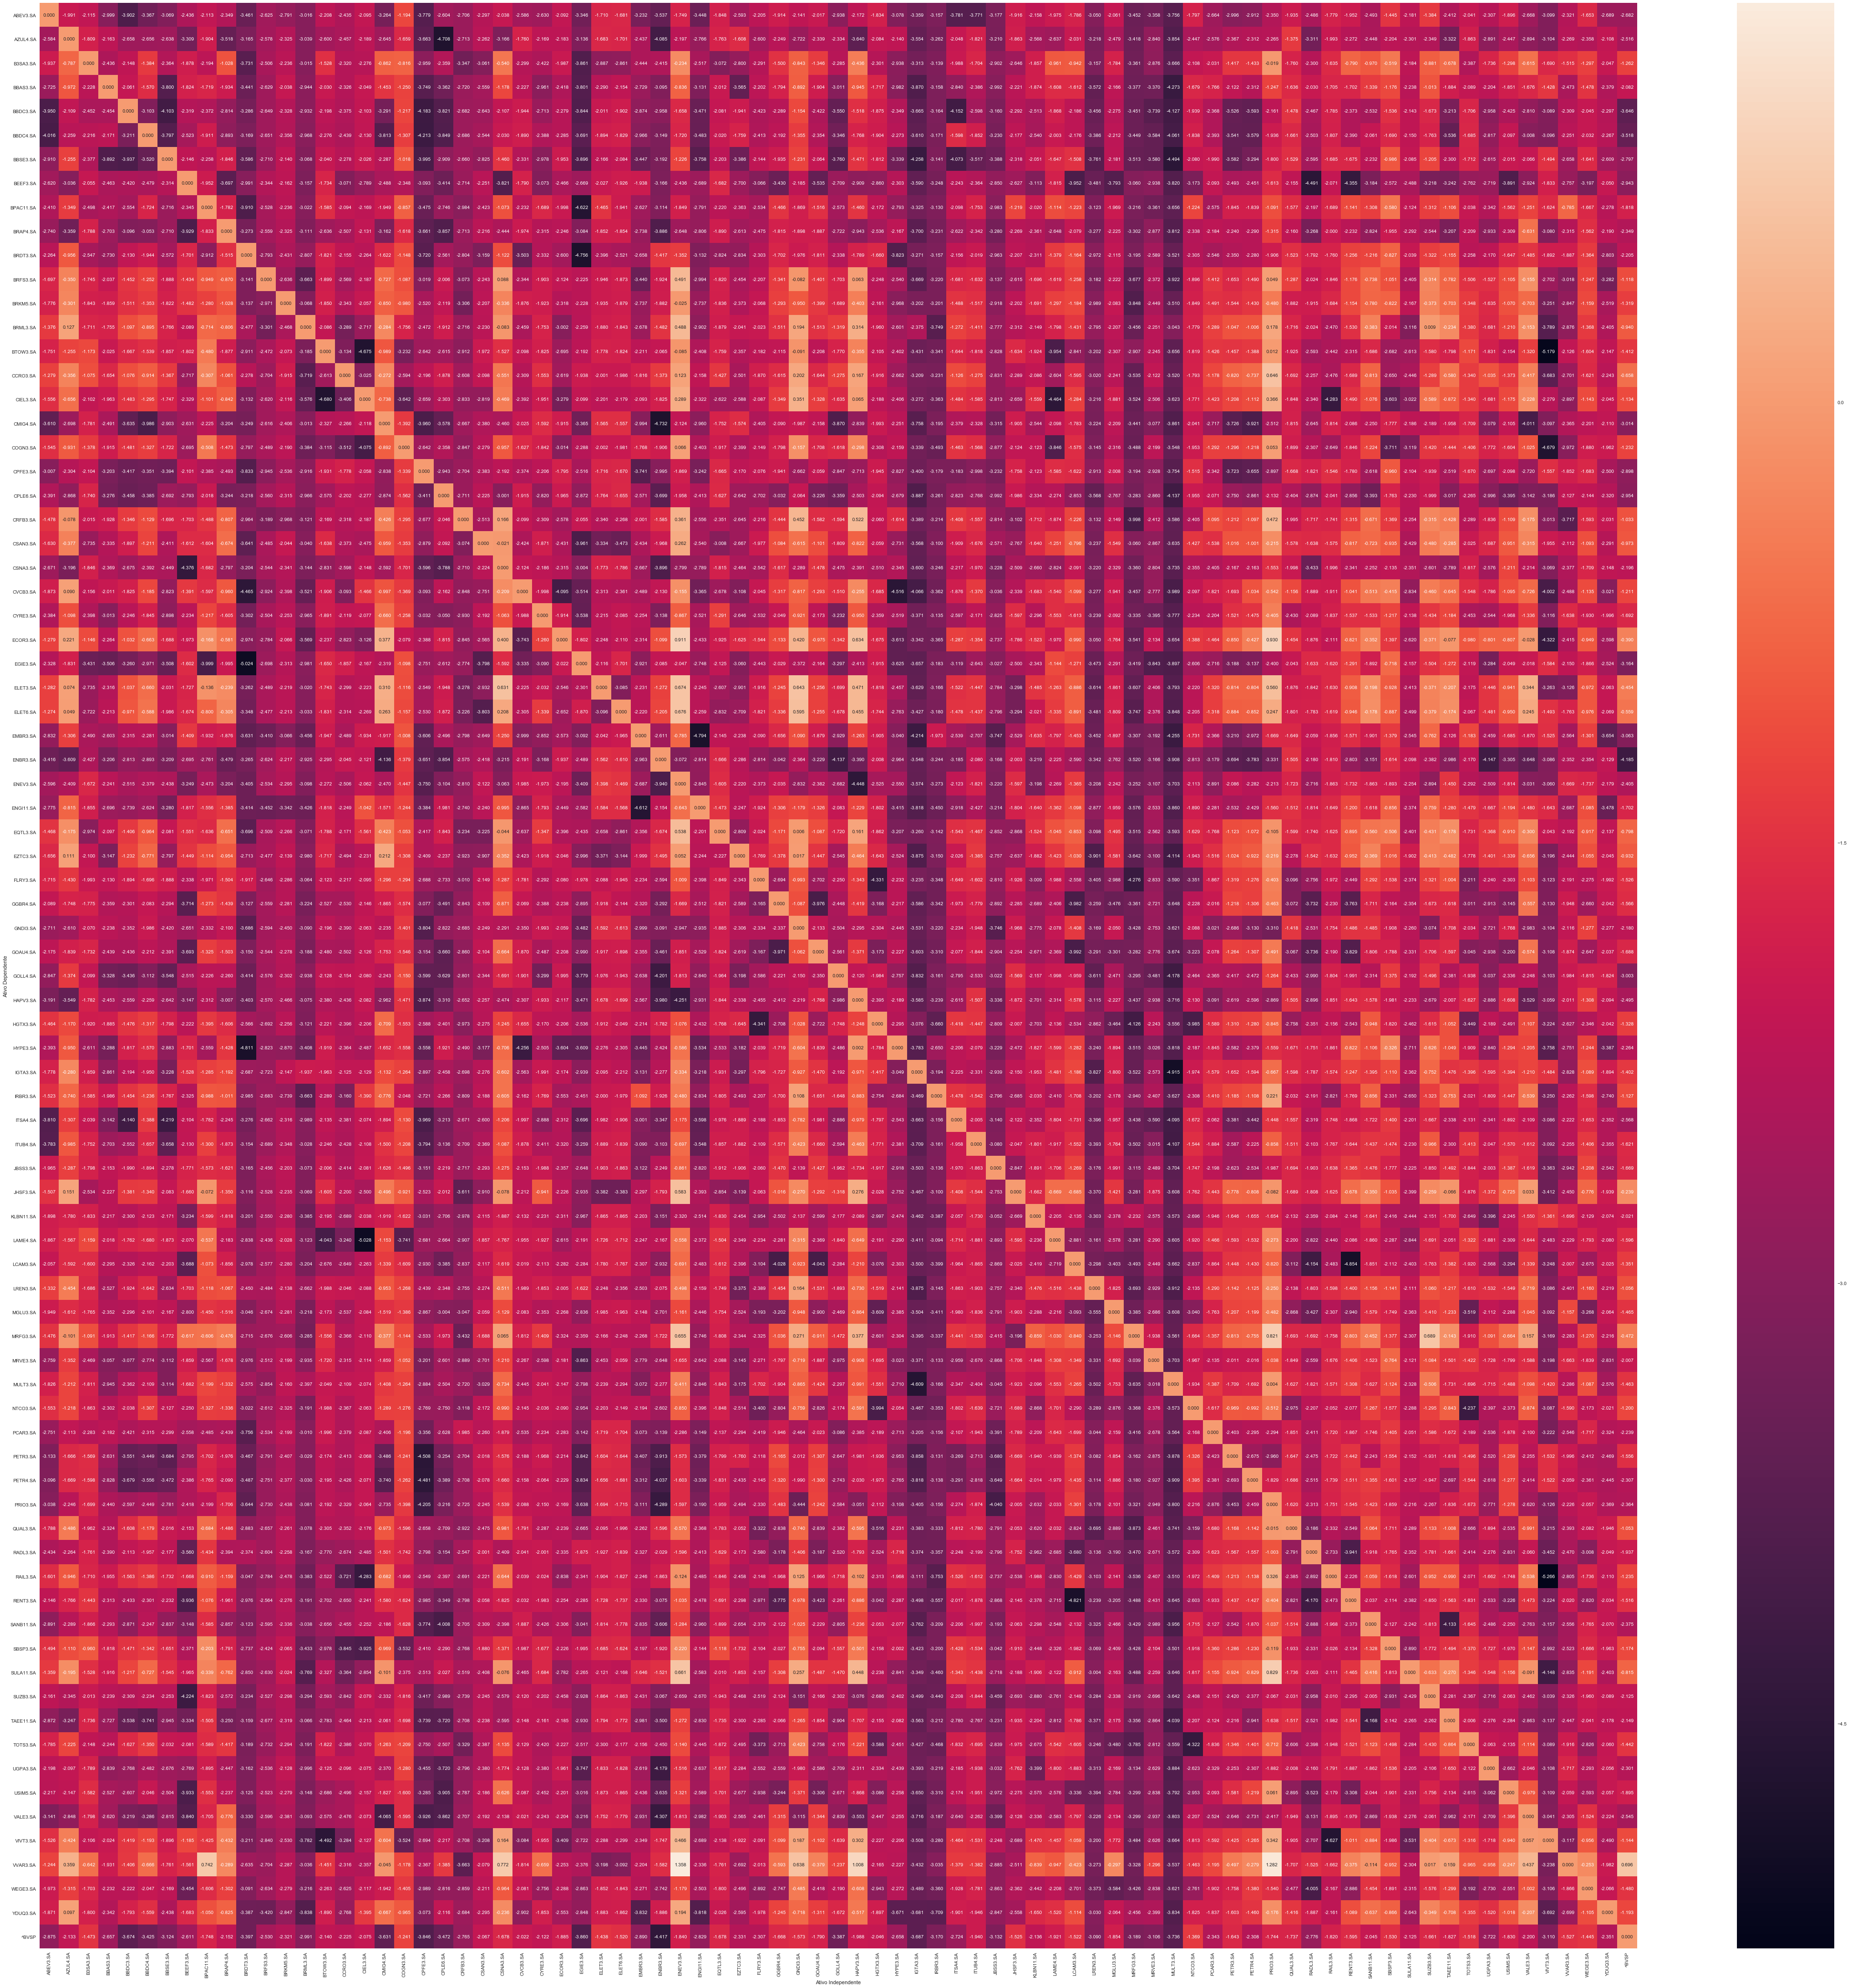

In [58]:
# Criando o mapa de calor
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(75, 75))

sns.heatmap(df, annot=True, fmt=".3f", ax=ax1)
ax1.set_xlabel('Ativo Independente')
ax1.set_ylabel('Ativo Dependente')
plt.savefig("heatmap.png")
;